# Ford GoBike Trip Data Analysis
## by Michael Mathias

## Investigation Overview

For the presentation, I focus on just the relationship between user_type, time_of_day, day_of_week and duration and I will also try to see how this features relate to user_age, I will leave out most of the other variables. I start by introducing the duration variable, followed by the pattern in the distribution of user_type, time_of_day and day_of_week. Then I will plot the relationship between each of this variable with duration.

Afterwards I will show relationship between user_age variable, time_of_day and day_of_week.


## Dataset Overview

The Ford GoBike Trip dataset includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df_biketrip = pd.read_csv('fordgobike_tripdata_clean.csv')

In [3]:
# Little cleaning of datatype on the dataset
#
# timestamp to datetime
df_biketrip['timestamp'] = pd.to_datetime(df_biketrip['timestamp'])

# Categorical variables converted from string to category
df_biketrip['user_gender'] = df_biketrip['user_gender'].astype('category') 
df_biketrip['user_type'] = df_biketrip['user_type'].astype('category')
df_biketrip['bike_share_for_all_trip'] = df_biketrip['bike_share_for_all_trip'].astype('category')

In [4]:
# Engineering more new featurs
df_biketrip['time_of_day'] = df_biketrip['timestamp'].dt.hour
df_biketrip['day_of_week'] = df_biketrip['timestamp'].dt.dayofweek

# Set the order for time_of_day
tod_order = np.arange(0, 24, 1)
tod_order = pd.api.types.CategoricalDtype(categories=tod_order, ordered=True)
df_biketrip['time_of_day'] = df_biketrip['time_of_day'].astype(tod_order)

# Set the order for day_of_week
dow_order = np.arange(0, 7, 1)
dow_order = pd.api.types.CategoricalDtype(categories=dow_order, ordered=True)
df_biketrip['day_of_week'] = df_biketrip['day_of_week'].astype(dow_order)

# Create tick labels for time of day
tod_labels = []
for time in tod_order.categories:
    if time == 0:
        tod_labels.append('12 AM')
    elif time < 12:
        tod_labels.append('{} AM'.format(time))
    elif time == 12:
        tod_labels.append('12 PM')
    else:
        tod_labels.append('{} PM'.format(time - 12))
        
# Create tick labels for day of week
dow_labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']

In [5]:
# Trim duration to values below 100
df_biketrip = df_biketrip.query('duration <= 100')

In [6]:
def log_transform(x, inverse=False):
    '''Function that computes the transform and inverse transform of a variable'''
    
    # Make sure x is not NaN or "-1"
    if x == x and x != -1:
        return 10 ** x if inverse else np.log10(x)
    
    return x

# Log transform of duration
df_biketrip['log_duration'] = df_biketrip['duration'].apply(log_transform)

# Log tranform of user_age
df_biketrip['log_user_age'] = df_biketrip['user_age'].apply(log_transform)

# Dataframe with trimmed user age data
# Remember aga NaN is stored as -1
df_trimmed_age = df_biketrip.query('user_age > -1')

## Distribution of Trip Duration

The distribution of duration takes on very wide range of values from as low as **about 1 minute** to as high as about **100 minutes** with alot of the data on shorter durations below **40 minutes**. When plotted on the log scale, the distribution takes on a bimodal distribution with peak values at around **4 - 5 minutes** marks and **10 minutes**. 

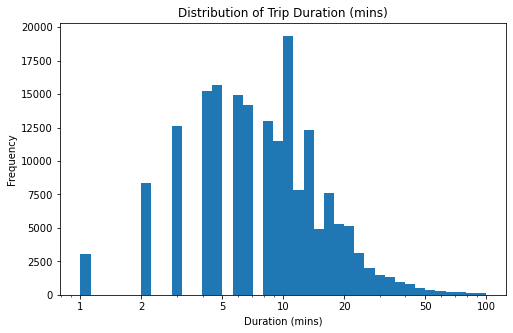

In [7]:
# Log transform distribution of duration of trip
log_binsize = 0.05
log_bins = 10 ** np.arange(0, np.log10(df_biketrip['duration'].max())+log_binsize, log_binsize);

x_ticks = [1, 2, 5, 10, 20, 50, 100]
x_ticklabels = ['{}'.format(x) for x in x_ticks]

plt.figure(figsize=(8, 5))
plt.hist(df_biketrip['duration'], bins=log_bins)
plt.xlabel('Duration (mins)')
plt.xscale('log')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Duration (mins)')
plt.xticks(x_ticks, x_ticklabels);

## Duration vs. User Type

Unsubscribed customers spend more time with there bikes than subscribed customers (we can see this more clearly in the box plots).

In [8]:
# Define seaborn base_color
base_color = sb.color_palette()[0]

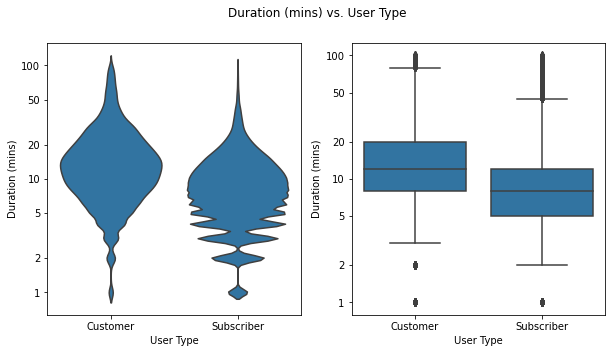

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

y_ticks = [1, 2, 5, 10, 20, 50, 100]
y_ticklabels = ['{}'.format(y) for y in y_ticks]
y_log_ticks = [log_transform(y) for y in y_ticks]

# violinplot on the left
plt.sca(ax[0])
sb.violinplot(x=df_biketrip['user_type'], y=df_biketrip['log_duration'], color=base_color, inner=None);
plt.yticks(y_log_ticks, y_ticklabels)
plt.xlabel('User Type')
plt.ylabel('Duration (mins)');

# boxplot on the right
plt.sca(ax[1])
sb.boxplot(x=df_biketrip['user_type'], y=df_biketrip['log_duration'], color=base_color);
plt.yticks(y_log_ticks, y_ticklabels);
plt.xlabel('User Type')
plt.ylabel('Duration (mins)');

fig.suptitle('Duration (mins) vs. User Type');

## Time of Day vs. Day of Week

We observe how effective and important the **Ford GoBike share** program is to the working class population. We notice two peaks on weekdays around **8 AM** and **5 PM**, which quickly disappears on weekends. Weekends even have more activities from **10 AM** to **3 PM** than the time periods for our peaks on weekdays.


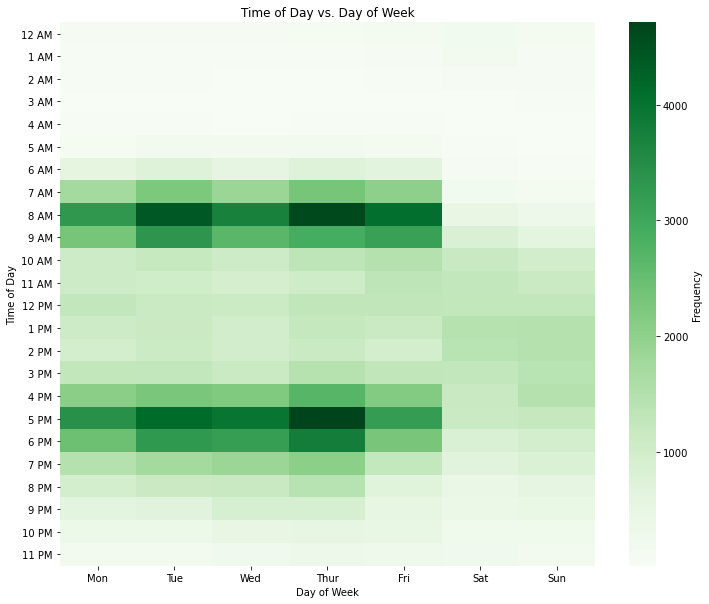

In [10]:
# Will visualization this multivariate relationship in a heatmap

# Ordinal categorical variables in the data
ordinal_vars = ['time_of_day', 'day_of_week']

data_matrix = df_biketrip.groupby(ordinal_vars).size().reset_index(name='count')

data_matrix = data_matrix.pivot(index='time_of_day', columns='day_of_week', values='count')

plt.figure(figsize=(12, 10))
sb.heatmap(data_matrix, cmap='Greens', cbar_kws={'label': 'Frequency'})
plt.xticks(dow_order.categories + 0.5, dow_labels)
plt.yticks(tod_order.categories + 0.5, tod_labels, rotation=0);
plt.xlabel('Day of Week')
plt.ylabel('Time of Day')
plt.title('Time of Day vs. Day of Week');

## Duration vs. Time of Day and Day of Week

Users tend to spend more time on average per trip on weekends than they do on weekdays, maybe because they don't have to rush to get to work and so they take there time.

We can notice this weekend activities split into two sections, 3-5 AM (People working out and so they take longer time on average per trip knowing they don't have to go to work for the day), and 10 AM -  5PM (People just crusing on the bike).

This also highlights the fact that when people are in a haste to get to work, the don't spend too much time on trip which is why we can observe the short durations at 8AM and 5 PM on weekdays when most people go to work.



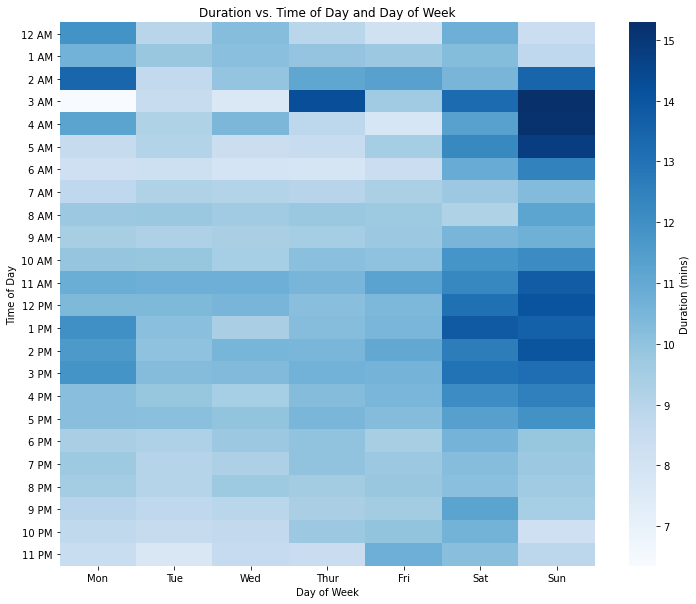

In [11]:
# Create matrix kind of dataset for our seaborn heatmap function
data_matrix = df_biketrip.groupby(ordinal_vars)['duration'].mean().reset_index(name='avg_duration')

# Pivot datatframe to have accurate mapping of variables.
data_matrix = data_matrix.pivot(index='time_of_day', columns='day_of_week', values='avg_duration')

plt.figure(figsize=(12, 10))
sb.heatmap(data_matrix, cmap='Blues', cbar_kws={'label': 'Duration (mins)'})
plt.xticks(dow_order.categories + 0.5, dow_labels)
plt.yticks(tod_order.categories + 0.5, tod_labels, rotation=0);
plt.xlabel('Day of Week')
plt.ylabel('Time of Day')
plt.title('Duration vs. Time of Day and Day of Week');

## Duration vs. Time of Day and Day of Week

Here we see a peak at 4 AM that shows older people above 40 years, on average, majorly using the bike share service at this time. Interestingly this peak appears more stadily for weekdays and drifts abit to somewhere around 5 - 6 AM for weekends.

I would say that during work days most older people above 40 years, tend to work out (and most use the gobike program for this) early so they can have some time to prepare for work and on week ends their work out routines drift a little towards 6 AM since they don't have to go to work.

If you also look a little more closely, you will notice the age range of 30 - 37 years, on average, being more active on weekdays than on weekends.


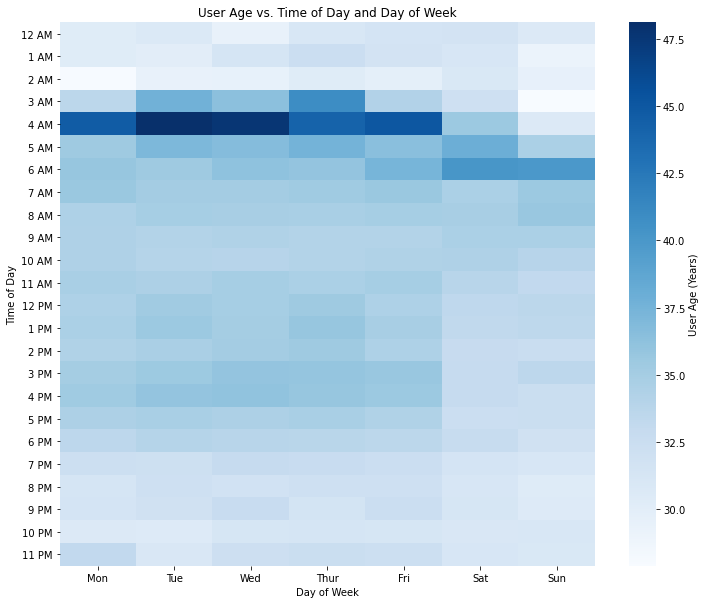

In [12]:
data_matrix = df_trimmed_age.groupby(ordinal_vars)['user_age'].mean().reset_index(name='avg_age')

# Pivot datatframe to have accurate mapping of variables.
data_matrix = data_matrix.pivot(index='time_of_day', columns='day_of_week', values='avg_age')

plt.figure(figsize=(12, 10))
sb.heatmap(data_matrix, cmap='Blues', cbar_kws={'label': 'User Age (Years)'})
plt.xticks(dow_order.categories + 0.5, dow_labels)
plt.yticks(tod_order.categories + 0.5, tod_labels, rotation=0);
plt.xlabel('Day of Week')
plt.ylabel('Time of Day')
plt.title('User Age vs. Time of Day and Day of Week');

In [ ]:
!jupyter nbconvert Part_II_slide_deck_template.ipynb --to slides --post serve --no-input --no-prompt